In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
range(0, 5, 1).tolist()

AttributeError: 'range' object has no attribute 'tolist'

In [9]:
df = pd.DataFrame({"A": [1, 2, 3, np.nan, 5], "B": [np.nan, 2, 3, 4, 5]})
df.dropna()

,A,B
0,2.0,2.0
1,3.0,3.0
2,5.0,5.0


In [2]:
np.random.seed(100)

df = pd.DataFrame(
    {
        "wind_direction": np.random.randint(0, 360, 100),
        "wind_speed": np.random.randint(0, 30, 100),
    }
)

# sectors = 16

# # Sectors are centered on the bin they represent, that means for 8 sectors,
# # I need to get angles [-22.5,22.5) binned in the "North" bin, not [0,45)
# df.loc[df["WindDirection"] > 360 - (360 / sectors / 2), "WindDirection"] -= 360

In [ ]:
pd

In [5]:
import pandas as pd


@pd.api.extensions.register_dataframe_accessor("rose")
class GeoAccessor:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    @property
    def center(self):
        # return the geographic center point of this DataFrame
        lat = self._obj.latitude
        lon = self._obj.longitude
        return (float(lon.mean()), float(lat.mean()))

    def plot(self):
        # plot this array's data on a map, e.g., using Cartopy
        pass

    def table(
        self,
        dir_column="wind_direction",
        var_column="wind_speed",
        *,
        sectors=8,
        bins=range(0, 31, 5),
        normed=False,
    ):
        """Generate a table of binned counts

        Parameters
        ----------
        dir_column, var_columns: str
            The name of the column representing the wind direction and
            the variable (i.e., wind speed)
        sectors : int
            The number of direction sections
        bins : array
            The bins for the variable
        normed : bool
            If False, return bin counts.
            If True, return bin counts divided by total count.
        """
        df = self._obj
        df = df[[var_column, dir_column]]

        # TODO: remove any rows with nan values.

        # Direction bins (i.e., wind direction bins)
        # Sectors are centered on the bin they represent. For example,
        # for 8 sectors I need to get angles [-22.5,22.5) binned in the
        # "North" bin, not [0,45).
        width = 360 / sectors
        dir_bins = np.arange(-width / 2, 360, width)
        df.loc[df[dir_column] > 360 - (width / 2), dir_column] -= 360

        # Variable bins (i.e., wind speed bins)
        var_bins = pd.IntervalIndex.from_breaks(
            list(bins) + [float("inf")], closed="left"
        )

        # Create the bins
        df["dir_bin"] = pd.cut(df[dir_column], dir_bins)
        df["var_bin"] = pd.cut(df[var_column], var_bins)

        # Group the data by wind direction and wind speed bins
        grouped = df.groupby(["dir_bin", "var_bin"])
        table = grouped.size().unstack()

        if normed:
            # TODO: does this account for any nan's?
            table = table / len(df)

        return table

    def bar(self, **kwargs):
        """Plot the binned data as a simple bar plot"""
        table = self._obj.rose.table(**kwargs)
        ax = table.plot(kind="bar", stacked=True, figsize=(12, 6), zorder=100)

        # Set labels and title
        plt.xlabel("Wind Direction bins (degrees)")
        plt.ylabel("Frequency")

        ax.grid(ls="--", alpha=0.5)

        return ax

    def plot(self, **kwargs):
        """Plot the binned data as a windrose"""
        table = self._obj.rose.table(**kwargs)
        nsectors, nbins = table.shape
        radian_locs = np.arange(0, np.pi * 2, np.pi * 2 / len(table))

        ax = plt.subplot(projection="polar")
        ax.set_theta_zero_location("N")  # theta=0 at the top
        ax.set_theta_direction(-1)  # theta increasing clockwise

        for i, color in zip(range(nbins), plt.get_cmap("viridis", nbins).colors):
            ax.bar(
                radian_locs,
                table.T.iloc[i],
                width=np.deg2rad(360 / nsectors) - np.deg2rad(5),
                bottom=table.T.iloc[0:i].sum(),
                color=color,
                # alpha=0.6,
                # edgecolor="k",
                # linewidth=0.5,
                label=table.T.iloc[i].name,
                zorder=2,
            )
        # TODO: specify rmax
        # ax.set_rmax(15)

        # TODO: set theta angle names
        # ax.set_xticks(radian_locs, ["N", "NE", "E", "SE", "S", "SW", "W", "SW"], fontsize=15)
        # ax.set_yticks(range(2, 20, 4), range(2, 20, 4), fontsize=10, zorder=10)

        ax.legend(fontsize=10, bbox_to_anchor=(1.5, 0.5))

        plt.tick_params(
            axis="both",
            which="both",
            direction="out",
            length=5,
            width=2,
            colors="r",
            zorder=10000,
        )

        # TODO: Why can't bars be on top of grid and below tick labels at the same time?

        return ax

In [6]:
df.rose.table(sectors=8)

var_bin,"[0.0, 5.0)","[5.0, 10.0)","[10.0, 15.0)","[15.0, 20.0)","[20.0, 25.0)","[25.0, 30.0)","[30.0, inf)"
dir_bin,,,,,,,
"(-22.5, 22.5]",3,3,1,2,3,2,0
"(22.5, 67.5]",0,1,1,3,1,3,0
"(67.5, 112.5]",2,3,2,3,3,1,0
"(112.5, 157.5]",1,0,2,1,3,3,0
"(157.5, 202.5]",1,2,1,1,4,5,0
"(202.5, 247.5]",1,3,2,4,1,2,0
"(247.5, 292.5]",5,2,2,0,1,2,0
"(292.5, 337.5]",2,1,4,3,2,2,0


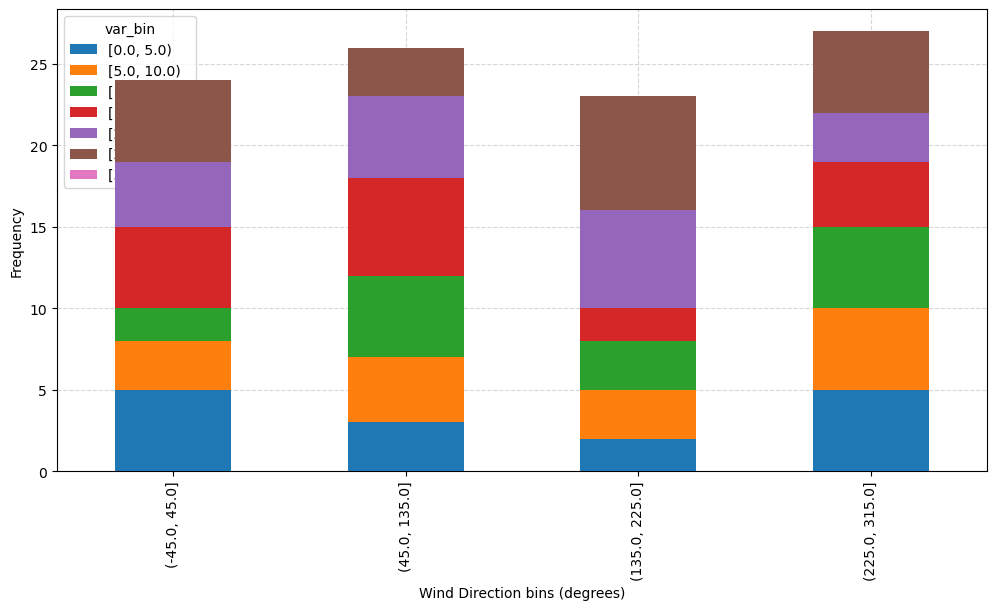

In [7]:
df.rose.bar(sectors=4)

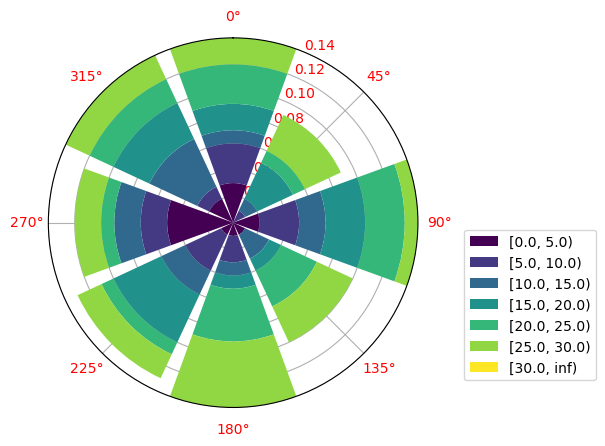

In [8]:
df.rose.plot()

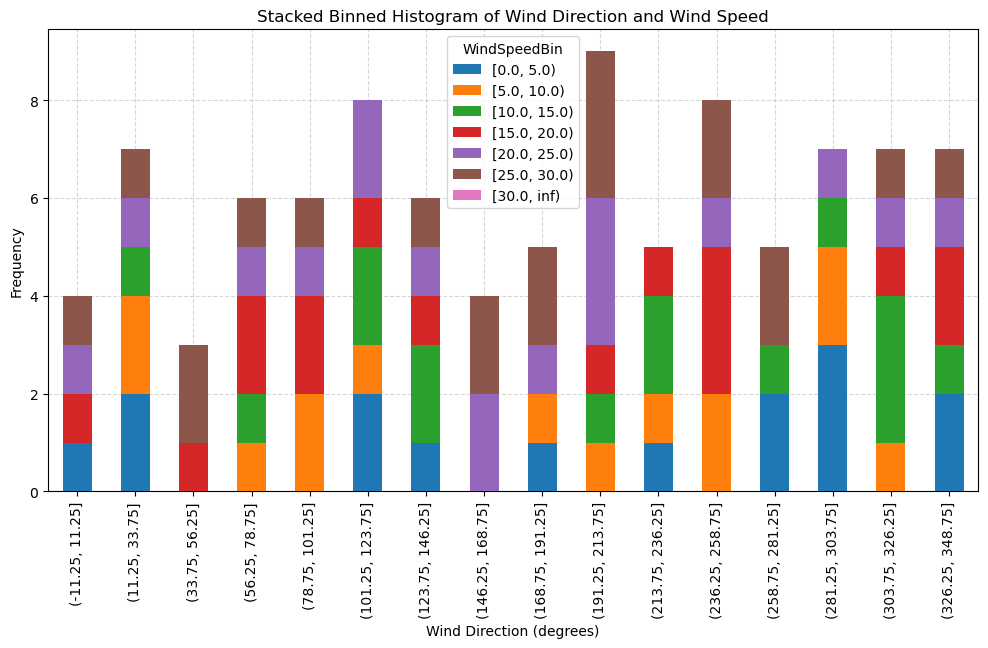

In [135]:
# Define bins for wind direction and wind speed
wind_dir_bins = np.arange(
    -360 / sectors / 2, 360, 360 / sectors
)  # 45-degree bins for wind direction
wind_speed_bins = pd.IntervalIndex.from_breaks(
    list(range(0, 31, 5)) + [float("inf")], closed="left"
)  # 5-knot bins for wind speed

# Sectors are centered on the bin they represent, that means for 16 sectors,
# I need to get angles [-22.5,22.5) binned in the "North" bin, not [0,45)
offset = 360 / (len(wind_dir_bins) - 1) / 2
df["WindDirection_OFFSET"] = (df.WindDirection + offset) % 360

# Categorize the wind direction and wind speed data into the specified bins
df["WindDirectionBin"] = pd.cut(df["WindDirection_OFFSET"], wind_dir_bins)
df["WindSpeedBin"] = pd.cut(df["WindSpeed"], wind_speed_bins)

# Group the data by wind direction and wind speed bins
grouped = df.groupby(["WindDirectionBin", "WindSpeedBin"]).size().unstack()

# Plot the stacked binned histogram
ax = grouped.plot(kind="bar", stacked=True, figsize=(12, 6), zorder=100)

# Set labels and title
plt.xlabel("Wind Direction (degrees)")
plt.ylabel("Frequency")
plt.title("Stacked Binned Histogram of Wind Direction and Wind Speed")

ax.grid(ls="--", alpha=0.5)

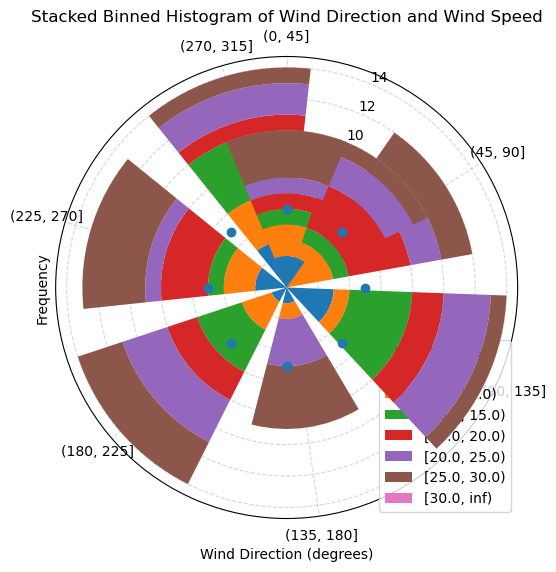

In [131]:
# TODO: Center direction bin sections

# Define bins for wind direction and wind speed
wind_dir_bins = np.arange(0, 361, 45)  # 45-degree bins for wind direction
wind_speed_bins = pd.IntervalIndex.from_breaks(
    list(range(0, 31, 5)) + [float("inf")], closed="left"
)  # 5-knot bins for wind speed


# Categorize the wind direction and wind speed data into the specified bins
df["WindDirectionBin"] = pd.cut(df["WindDirection"], wind_dir_bins)
df["WindSpeedBin"] = pd.cut(df["WindSpeed"], wind_speed_bins)

# Group the data by wind direction and wind speed bins
grouped = df.groupby(["WindDirectionBin", "WindSpeedBin"]).size().unstack()

# Plot the stacked binned histogram
ax = plt.subplot(projection="polar")
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
grouped.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    zorder=100,
    ax=ax,
    width=np.pi * 2 / 8,
)
ax.set_xlim(0, np.pi * 2)

ax.scatter(
    np.arange(0, np.pi * 2, np.pi * 2 / 8), [5, 5, 5, 5, 5, 5, 5, 5], zorder=1000
)

# Set labels and title
plt.xlabel("Wind Direction (degrees)")
plt.ylabel("Frequency")
plt.title("Stacked Binned Histogram of Wind Direction and Wind Speed")

ax.grid(ls="--", alpha=0.5)

# TODO: ================================================================
# TODO: The issue here is that you can't change the bar locations in
# TODO: the Pandas bar plotting method. May need to plot manually.
# TODO: ================================================================

In [129]:
grouped.T

WindDirectionBin,"(-11.25, 11.25]","(11.25, 33.75]","(33.75, 56.25]","(56.25, 78.75]","(78.75, 101.25]","(101.25, 123.75]","(123.75, 146.25]","(146.25, 168.75]","(168.75, 191.25]","(191.25, 213.75]","(213.75, 236.25]","(236.25, 258.75]","(258.75, 281.25]","(281.25, 303.75]","(303.75, 326.25]","(326.25, 348.75]"
WindSpeedBin,,,,,,,,,,,,,,,,
"[0.0, 5.0)",1,2,0,0,0,2,1,0,1,0,1,0,2,3,0,2
"[5.0, 10.0)",0,2,0,1,2,1,0,0,1,1,1,2,0,2,1,0
"[10.0, 15.0)",0,1,0,1,0,2,2,0,0,1,2,0,1,1,3,1
"[15.0, 20.0)",1,0,1,2,2,1,1,0,0,1,1,3,0,0,1,2
"[20.0, 25.0)",1,1,0,1,1,2,1,2,1,3,0,1,0,1,1,1
"[25.0, 30.0)",1,1,2,1,1,0,1,2,2,3,0,2,2,0,1,1
"[30.0, inf)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [133]:
sectors, bins

(8, 7)

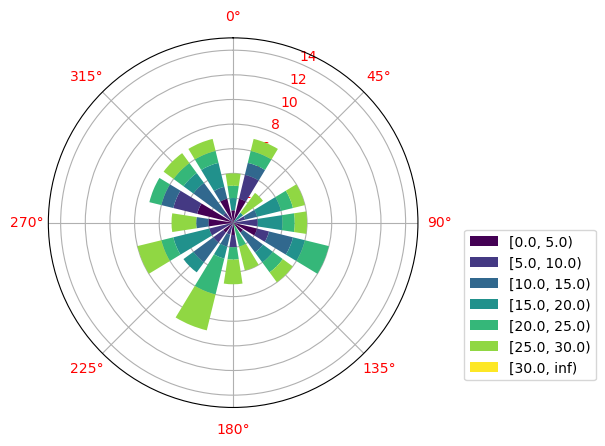

In [139]:
sectors, bins = grouped.shape
radian_locs = np.arange(0, np.pi * 2, np.pi * 2 / len(grouped))

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise

for i, color in zip(range(bins), plt.get_cmap("viridis", bins).colors):
    ax.bar(
        radian_locs,
        grouped.T.iloc[i],
        width=np.deg2rad(360 / sectors) - np.deg2rad(5),
        bottom=grouped.T.iloc[0:i].sum(),
        color=color,
        # alpha=0.6,
        # edgecolor="k",
        # linewidth=0.5,
        label=grouped.T.iloc[i].name,
        zorder=2,
    )
ax.set_rmax(15)
ax.legend(fontsize=10, bbox_to_anchor=(1.5, 0.5))

# ax.set_xticks(radian_locs, ["N", "NE", "E", "SE", "S", "SW", "W", "SW"], fontsize=15)
# ax.set_yticks(range(2, 20, 4), range(2, 20, 4), fontsize=10, zorder=10)

plt.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=5,
    width=2,
    colors="r",
    zorder=10000,
)